# Analysis of a run with constraints, and a run without

I have made a little analysis to test our ability to date a tree with node order constraints. I use the following tree:

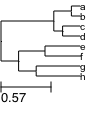

In [53]:
import sys
from ete3 import Tree, TreeStyle, NodeStyle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy
import re

t = Tree("(((a:0.1,b:0.1):0.2, (c:0.2,d:0.2):0.1):0.6, ((e:0.4,f:0.4):0.3, (g:0.5,h:0.5):0.2):0.2);")
ts = TreeStyle()
ts.min_leaf_separation= 0
ts.scale = 88 
nstyle = NodeStyle()
nstyle["size"] = 0
for n in t.traverse():
   n.set_style(nstyle)

t.render("%%inline", tree_style=ts)  

Then I will compare two MCMC runs: one with 2 node order constraints, and one without.
The node order constraints are as follow:

c       d       a       b

g       h       e       f

meaning that the MRCA of cd is older than the MRCA of AB (same thing for the second line), just like in the tree.
First we take a short look at the MCMC run.

In [58]:


runConsMet = pd.read_csv("output/testConstraintsMet.log", sep="\t")

In [59]:
runConsMet.describe()

,Iteration,Posterior,Likelihood,Prior,diversification,extinction,gc,root,speciation,tstv,turnover
count,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,5000.000000,-113.993874,-98.425971,-15.567914,4.416536,5.334900,0.111875,0.774875,9.751436,0.942513,5.334900
std,2891.081113,2.214749,1.565877,1.904898,1.507350,2.319868,0.107302,0.198239,2.547804,0.552286,2.319868
min,0.000000,-123.309000,-105.959000,-23.481300,0.738713,0.506599,0.000130,0.305117,3.853600,0.064296,0.506599
25%,2500.000000,-115.260000,-99.369100,-16.632500,3.373290,3.620480,0.032300,0.635708,7.979750,0.528046,3.620480
50%,5000.000000,-113.593000,-98.226200,-15.475800,4.261310,4.927260,0.080141,0.770879,9.403520,0.833976,4.927260
75%,7500.000000,-112.454000,-97.292100,-14.235800,5.233970,6.774960,0.153066,0.893176,11.209300,1.241400,6.774960
max,10000.000000,-109.414000,-94.888500,-10.750500,11.936400,17.340100,0.672720,1.806330,22.550600,3.337300,17.340100


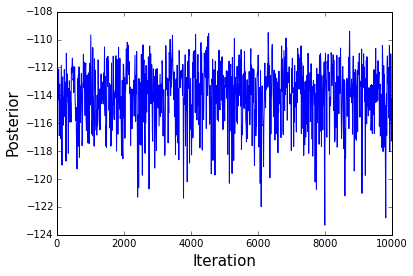

In [60]:
%matplotlib inline
plt.plot(runConsMet['Iteration'], runConsMet['Posterior'], 'b-')
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Posterior", fontsize=15)




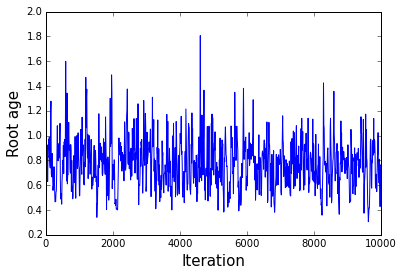

In [61]:
%matplotlib inline
plt.plot(runConsMet['Iteration'], runConsMet['root'], 'b-')
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Root age", fontsize=15)




In [62]:
def readTreesFromRBOutput (file):
    try:
        f=open(file, 'r')
    except IOError:
        print ("Unknown file: "+file)
        sys.exit()
    line = ""
    treeStrings = list()
    for l in f:
        if "teration" not in l:
            m = re.sub('\[&index=\d+\]', "", l)
            treeStrings.append(m.split()[4])
    trees=list()
    for l in treeStrings:
        trees.append ( Tree( l ) )
    return trees

trees = readTreesFromRBOutput("output/testConstraintsMet.trees")


In [63]:

def getNodeHeights( t ):
    node2Height = dict()
    id2Height = dict()
    for node in t.traverse("postorder"):
        if node not in node2Height:
            node2Height[node] = 0.0
            id2Height[node.name] = 0.0
        if node.up:
            if node.up.name =='':
                leaves = node.up.get_leaves()
                name=""
                for l in leaves:
                    name += l.name
                node.up.name=name
            node2Height[node.up] = node2Height[node] + node.dist
            id2Height[str(node.up.name)] = node2Height[node] + node.dist
      # print node.name + " : " + str(node2Height[node])
    #return node2Height,id2Height
    return id2Height


allHeights = list()
for t in trees:
    allHeights.append(getNodeHeights(t))

Let's look at the age difference between two nodes constrained in an older-younger fashion (the first constraint.

In [64]:
diffABMinusCD = list()
for a in allHeights:
    diffABMinusCD.append(a["ab"] - a["cd"])

pd.DataFrame( diffABMinusCD ).describe()
    
    

,0
count,1001.000000
mean,-0.146086
std,0.113012
min,-0.629282
25%,-0.205406
50%,-0.122005
75%,-0.059797
max,-0.000474


They are all negative, and thus agree with the constraint.
We look at the other constraint.

In [65]:
diffEFMinusGH = list()
for a in allHeights:
    diffEFMinusGH.append(a["ef"] - a["gh"])

pd.DataFrame( diffEFMinusGH ).describe()

,0
count,1001.000000
mean,-0.147083
std,0.114754
min,-0.598449
25%,-0.216569
50%,-0.123322
75%,-0.055978
max,-0.000051


Same thing. 
Now we look into an unconstrained run.

In [66]:
treesNC = readTreesFromRBOutput("output/testNoConstraint.trees")
allHeightsNC = list()
for t in treesNC:
    allHeightsNC.append(getNodeHeights(t))

diffABMinusCDNC = list()
for a in allHeightsNC:
    diffABMinusCDNC.append(a["ab"] - a["cd"])

pd.DataFrame( diffABMinusCDNC ).describe()

,0
count,1001.000000
mean,-0.014525
std,0.258753
min,-1.001023
25%,-0.172961
50%,-0.019800
75%,0.144513
max,1.010819


The difference is not always negative.

In [67]:
diffEFMinusGHNC = list()
for a in allHeightsNC:
    diffEFMinusGHNC.append(a["ef"] - a["gh"])

pd.DataFrame( diffEFMinusGHNC ).describe()

,0
count,1001.000000
mean,-0.012098
std,0.265463
min,-1.402574
25%,-0.152929
50%,-0.003269
75%,0.140969
max,0.970412


In this case as well, the difference is not always negative.

# To conclude, it seems like the constraints have an impact on the posterior chronogram distribution, so we have a program to do relaxed molecular clock with node order constraints.